# Capstone Project - Battle of the Neighborhoods

_Applied Data Science Specialization by IBM_

---

**1. Introduction**  
Definition of the business problem and the target audience.  
**2. Data**  
Description of the data and sources used to solve the problem.  
**3. Methodology**  
Discussion of the exploratory data analysis, the inferential statistical testing, and the machine learnings that were used.  
**4. Results**  
Presentation of the results.  
**5. Discussion**  
Observations and recommendations based on the results.  
**6. Conclusion**  
Final thoughts on the report.

---

## 1. Introduction

The owners of a successful gallery in Manhattan are looking at the prospect of expanding their business. Having considered many options for growth, they came to the conclusion that opening a second physical location is going to be their next move and San Fransisco was determined as the most ideal city for their target clientele.

Our objective is to use data science in order to **choose the ideal location for the new gallery.**

We will focus on some of the most *critical factors* that will contribute to the gallery's profitability, such as:

1. Neighborhood safety, accessibility and visibility
2. Surrounding businesses and possible competitors
3. Space size and affordability  
4. Comparative analysis of the neighborhoods of the existing and proposed locations


## 2. Data

In order to approach the above-mentioned factors we will need to use different types of data from the available sources.

* To determine the safety factor, we will use the *San Fransisco Police Department's dataset* that can provide us with incident reports filed by officers and by individuals through self-service online reporting for non-emergency cases.
* To estimate how accessible the potential location will be by public or private means, we will refer to *San Fransisco's public transportation geodata* such as subway and bus stations as well as the *MTA's on- and off- street parking census*.
* Using *Foursquare* to extract the most popular venues in the city we will establish the visibility factor that different neighborhoods can provide.
* *Foursquare* analysis will be also used to avoid competition while simultaneously benefit from proximity with complimentary venues such as cafes and restaurants.
* Information regarding spaces sizes and rending costs will be gathered from *real estate agencies* and *accommodation search engines*.
* Since the existing gallery location is proved to have contributed to a successful business model in New York, we will critically compare the data for the two cities, in order to support our final location proposal.

---

## 3. Methodology

Firstly, download all the dependencies that are going to be used for the data analysis.

In [37]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import geopandas as gpd
from geopandas.tools import sjoin
from geopandas import GeoDataFrame

import requests # library to handle requests

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium.plugins import FastMarkerCluster

# improt BeautifulSoup for data scraping
from bs4 import BeautifulSoup

import pysal as ps
from shapely.geometry import Point

%matplotlib inline

print('Prerequisites imported!')

Prerequisites imported!


### 3.1 Safety factor analysis

Load and explore the San Fransisco Police Department's dataset (from https://data.sfgov.org/d/wg3w-h783).

In [38]:
df_incidents = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")
df_incidents.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point
0,2018/10/22 10:50:00 AM,2018/10/22,10:50,2018,Monday,2018/10/22 11:24:00 AM,72897505073,728975,180801798,182951518.0,II,Initial,NaN,5073,Burglary,Burglary - Other,"Burglary, Other Bldg., Unlawful Entry",Open or Active,VAN NESS AVE \ OAK ST,30705000.0,Northern,Tenderloin,6.0,37.775422,-122.419397,"(37.7754222198843, -122.41939688941916)"
1,2018/08/24 02:50:00 PM,2018/08/24,14:50,2018,Friday,2018/08/24 02:52:00 PM,72925174010,729251,180638466,181362475.0,II,Initial,NaN,74010,Missing Person,Missing Juvenile,Missing Juvenile,Open or Active,28TH AVE \ VICENTE ST,23250000.0,Taraval,Sunset/Parkside,4.0,37.738900,-122.485074,"(37.738899869536326, -122.48507449528636)"
2,2018/10/14 02:54:00 PM,2018/10/14,14:54,2018,Sunday,2018/10/24 01:10:00 PM,72980906303,729809,180807520,182971760.0,II,Initial,NaN,6303,Larceny Theft,Larceny Theft - From Building,"Theft, From Building, $200-$950",Open or Active,PINTO AVE \ ARBALLO DR,23104000.0,Taraval,Lakeshore,7.0,37.720450,-122.483015,"(37.7204499957522, -122.48301534194144)"
3,2018/10/14 02:54:00 PM,2018/10/14,14:54,2018,Sunday,2018/10/24 01:10:00 PM,72980964070,729809,180807520,182971760.0,II,Initial,NaN,64070,Suspicious Occ,Suspicious Occ,Suspicious Occurrence,Open or Active,PINTO AVE \ ARBALLO DR,23104000.0,Taraval,Lakeshore,7.0,37.720450,-122.483015,"(37.7204499957522, -122.48301534194144)"
4,2018/10/18 04:40:00 PM,2018/10/18,16:40,2018,Thursday,2018/10/26 07:42:00 AM,73011316650,730113,180791014,182911410.0,IS,Initial Supplement,NaN,16650,Drug Offense,Drug Violation,Methamphetamine Offense,Cite or Arrest Adult,BOARDMAN PL \ BRYANT ST,23914000.0,Southern,South of Market,6.0,37.775161,-122.403636,"(37.7751608100771, -122.40363551943442)"


Examine the size of the dataframe.

In [39]:
print('The dataframe consists of {} rows.'.format(df_incidents.shape[0]))

The dataframe consists of 169046 rows.


Cleanup the dataframe by removing unnecessary columns and values.

In [40]:
# remove the unnecessary columns
columns = ['Incident Datetime', 'Incident Day of Week', 'Incident Year', 'Report Datetime', 
           'Row ID', 'Incident ID', 'CAD Number', 'Report Type Code', 
           'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Subcategory', 
           'Incident Description', 'Intersection', 'CNN', 'Analysis Neighborhood', 
           'Supervisor District', 'Resolution', 'point']
df_incidents.drop(columns, axis=1, inplace=True)

# remove the rows with missing values
df_incidents.dropna(inplace=True)

df_incidents.head()

,Incident Date,Incident Time,Incident Number,Incident Category,Police District,Latitude,Longitude
0,2018/10/22,10:50,180801798,Burglary,Northern,37.775422,-122.419397
1,2018/08/24,14:50,180638466,Missing Person,Taraval,37.738900,-122.485074
2,2018/10/14,14:54,180807520,Larceny Theft,Taraval,37.720450,-122.483015
3,2018/10/14,14:54,180807520,Suspicious Occ,Taraval,37.720450,-122.483015
4,2018/10/18,16:40,180791014,Drug Offense,Southern,37.775161,-122.403636


In [41]:
print('The dataframe now consists of {} rows.'.format(df_incidents.shape[0]))

The dataframe now consists of 160489 rows.


In [42]:
# count the unique incident occurences
df_incidents['Incident Category'].value_counts()

Larceny Theft                                 47883
Other Miscellaneous                           13124
Non-Criminal                                  10415
Assault                                        9897
Malicious Mischief                             9240
Burglary                                       7606
Warrant                                        6142
Motor Vehicle Theft                            5690
Lost Property                                  4977
Missing Person                                 4926
Fraud                                          4777
Drug Offense                                   4453
Robbery                                        4039
Offences Against The Family And Children       3761
Recovered Vehicle                              3545
Suspicious Occ                                 2974
Disorderly Conduct                             2805
Traffic Violation Arrest                       2276
Miscellaneous Investigation                    1422
Other Offens

In [43]:
# remove the incidents that don't seem to directly influence the safety factor of the neighbourhood
non_violent = ['Non-Criminal', 'Fraud', 'Disorderly Conduct', 'Case Closure', 
               'Civil Sidewalks', 'Courtesy Report', 'Embezzlement','Gambling']

for i in range (0,len(non_violent)):
    df_incidents = df_incidents[df_incidents['Incident Category'] != non_violent[i]].reset_index(drop=True)

In [44]:
print('The dataframe now consists of {} rows.'.format(df_incidents.shape[0]))

The dataframe now consists of 140594 rows.


Identify and analyze the different incidents, their occurrences and relevance to a neighborhood's safety.

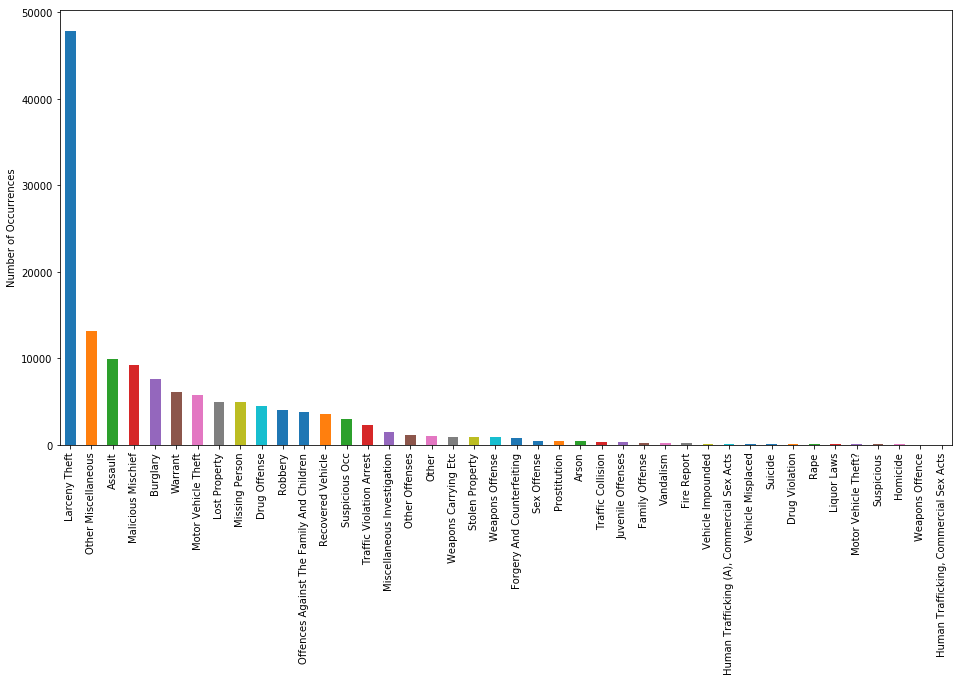

In [45]:
# visualize the incidents per category in a graph
df_incidents['Incident Category'].value_counts().plot(kind='bar', figsize=(16,8))
plt.ylabel('Number of Occurrences')
plt.show()

Visualize where the above-mentioned crimes took place in the city of San Francisco. 

In [46]:
# convert the Pandas dataframe into a GeoPandas GeoDataFrame
geometry = gpd.GeoSeries(df_incidents.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1), crs={'init': 'epsg:4326'})
df_incidents = gpd.GeoDataFrame(df_incidents, geometry=geometry)
df_incidents.head()


,Incident Date,Incident Time,Incident Number,Incident Category,Police District,Latitude,Longitude,geometry
0,2018/10/22,10:50,180801798,Burglary,Northern,37.775422,-122.419397,POINT (-122.4193968894192 37.7754222198843)
1,2018/08/24,14:50,180638466,Missing Person,Taraval,37.738900,-122.485074,POINT (-122.4850744952864 37.73889986953633)
2,2018/10/14,14:54,180807520,Larceny Theft,Taraval,37.720450,-122.483015,POINT (-122.4830153419414 37.7204499957522)
3,2018/10/14,14:54,180807520,Suspicious Occ,Taraval,37.720450,-122.483015,POINT (-122.4830153419414 37.7204499957522)
4,2018/10/18,16:40,180791014,Drug Offense,Southern,37.775161,-122.403636,POINT (-122.4036355194344 37.7751608100771)


Import the neighborhoods from:
https://data.sfgov.org/Geographic-Locations-and-Boundaries/Realtor-Neighborhoods/5gzd-g9ns/data

In [47]:
# San Francisco Neighborhoods
nbrhoods = gpd.read_file('Realtor_Neighborhoods.shp')

In [48]:
# Calculate the number of incidents in each neighborhood
nbh_incidents_counts = gpd.tools.sjoin(df_incidents.to_crs(nbrhoods.crs), nbrhoods, how="inner", op='intersects').groupby('nbrhood').size()
nbh_incidents_counts = pd.DataFrame(data=nbh_incidents_counts.reset_index())
nbh_incidents_counts.columns=['nbrhood', 'incident_counts']
nbh_incidents_counts.head()

,nbrhood,incident_counts
0,Alamo Square,941
1,Anza Vista,403
2,Balboa Terrace,65
3,Bayview,4604
4,Bayview Heights,371


In [49]:
# combine the nbh_incidents_counts and the nbrhoods GeoDataFrames using the merge function
nbrhoods = nbrhoods.merge(nbh_incidents_counts, on='nbrhood')
nbrhoods.head()

,nbrhood,nid,sfar_distr,geometry,incident_counts
0,Alamo Square,6e,District 6 - Central North,POLYGON ((-122.4294839489174 37.77509623070431...,941
1,Anza Vista,6a,District 6 - Central North,POLYGON ((-122.4474643913587 37.77986335309237...,403
2,Balboa Terrace,4a,District 4 - Twin Peaks West,"POLYGON ((-122.464508862148 37.73220849554402,...",65
3,Bayview,10a,District 10 - Southeast,"POLYGON ((-122.38758527039 37.7502633777501, -...",4604
4,Bernal Heights,9a,District 9 - Central East,POLYGON ((-122.4037549223623 37.74919006373567...,2144


In [50]:
del df_incidents

Generate Choreoplath Map using Folium

In [51]:
# generate a representative location for each neighborhood
nbh_centroid = pd.DataFrame(nbrhoods.centroid)
nbh_centroid = pd.DataFrame(nbrhoods.representative_point())
nbh_centroid.columns=(['centroid'])
nbh_centroid['nbrhood'] = nbrhoods['nbrhood']
nbh_centroid['incident_counts'] = nbrhoods['incident_counts']

lat = []
lng = []
for index, row in nbh_centroid.iterrows():
    tmp = str(row[0]).strip('POINT ()').split(' ')
    lng.append(float(tmp[0]))
    lat.append(float(tmp[1]))
    #print(tmp[0], tmp[1])
    
nbh_centroid['Latitude'] = lat
nbh_centroid['Longitude'] = lng

nbh_centroid = nbh_centroid.drop(columns=['centroid'])

nbh_centroid.head()

,nbrhood,incident_counts,Latitude,Longitude
0,Alamo Square,941,37.776076,-122.433919
1,Anza Vista,403,37.780611,-122.443255
2,Balboa Terrace,65,37.730649,-122.468267
3,Bayview,4604,37.732391,-122.387170
4,Bernal Heights,2144,37.740230,-122.415885


In [52]:
def get_popups(df, field, name, map_object):
    for lat, lng, nbrhood, value in zip( df['Latitude'], 
                                         df['Longitude'], 
                                         df['nbrhood'], 
                                         df[field]
                                       ):
        label = ("{0}, {1}: {2:.2f}").format(nbrhood, name, value)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='green',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3).add_to(map_object)

In [54]:
SF_Coord = (37.7792808, -122.4192363)

SF_incidents_map = folium.Map(location=SF_Coord, zoom_start=12)

threshold_scale = [0, 1000, 4000, 8000, 12000, 15000]
SF_incidents_map.choropleth(geo_data        = nbrhoods.to_json(),
                            data            = nbrhoods,
                            columns         = ['nbrhood', 'incident_counts'], 
                            key_on          = 'feature.properties.nbrhood',
                            fill_color      = 'YlOrRd', 
                            fill_opacity    = 0.60, 
                            line_opacity    = 0.60,
                            legend_name     = 'Number of incidents',
                            name            = 'Number of Incidents',
                            threshold_scale = threshold_scale,
                            reset = True)


get_popups(nbh_centroid, 'incident_counts', 'Incident Counts', SF_incidents_map)

# Add control layer to the map
folium.LayerControl().add_to(SF_incidents_map)
SF_incidents_map

### 3.2 Accessibility analysis

Load and explore the San Francisco MUNI Transit Stops, MTA.meteredstreetblocks, MTA.motoparking_unmetered, MTA.parkingcensus_offstreet

In [56]:
# I should load the geojson files and make a comparative analysis of the different maps.

### 3.3 Visibility analysis

Using Foursquare to extract the most popular venues in the city we will establish the visibility factor that different neighborhoods can provide.

In [57]:
# insert my Foursquare API credentials
CLIENT_ID = 'UTR00LCVHLJCMGTOPTJCLCGFQPNXXP2AIEHX1KDDYD3AVS4U'
CLIENT_SECRET = 'R1AKVTFPKYL4DHGC45B20MPJPHFBET0HA4XN1S4GUAL0MOVS'
VERSION = '20180604'

# Set up the call parameters
RADIUS = 500
LIMIT  = 100

Define the function that extracts the category of the venue.

In [58]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define the function that explores the most popular venues for each neighborhood.

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_check_list = []
    venues_list=[]
    idx = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        num_of_venues_found = len(results)
        if (num_of_venues_found == 0):
            venues_check_list.append(False)
        else:
            venues_check_list.append(True)
        print('{0:4d} Neighborhood: {1:35s}, number of venues found:{2:6d}'.format(idx, name, num_of_venues_found))
        idx = idx + 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['nbrhood', 
                  'nbrhood Latitude', 
                  'nbrhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_check_list)

Get the 100 most popular venues at a 500m radius for all San Francisco neighborhoods.

In [78]:
nbhs = nbh_centroid.loc[:, 'nbrhood']
latitudes = nbh_centroid.loc[:, 'Latitude']
longitudes = nbh_centroid.loc[:, 'Longitude']

print('\n            Search radius: {0:8.1f} meters'.format(RADIUS))
print(' Maximum number of venues: {0:6d}\n'.format(LIMIT))
SF_venues, SF_venues_check_list = getNearbyVenues(nbhs, latitudes, longitudes, RADIUS, LIMIT)



            Search radius:    500.0 meters
 Maximum number of venues:    100

   0 Neighborhood: Alamo Square                       , number of venues found:    73
   1 Neighborhood: Anza Vista                         , number of venues found:    19
   2 Neighborhood: Balboa Terrace                     , number of venues found:    18
   3 Neighborhood: Bayview                            , number of venues found:    12
   4 Neighborhood: Bernal Heights                     , number of venues found:    38
   5 Neighborhood: Buena Vista Park/Ashbury Heights   , number of venues found:    51
   6 Neighborhood: Central Richmond                   , number of venues found:   100
   7 Neighborhood: Central Sunset                     , number of venues found:    16
   8 Neighborhood: Clarendon Heights                  , number of venues found:    15
   9 Neighborhood: Corona Heights                     , number of venues found:    58
  10 Neighborhood: Cow Hollow                         , numbe

In [66]:
print('The search has returned {} venues in total.'.format((SF_venues.shape)[0]))

The search has returned 3600 venues in total.


In [67]:
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 344 uniques categories.


Cluster the neighborhoods using the k-means algorithm.

In [70]:
# one-hot encode the venue categories
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
SF_onehot['nbrhood'] = SF_venues['nbrhood'] 

# move postcode column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

# group rows by neighborhood name and events' frequency of occurrence
SF_grouped = SF_onehot.groupby('nbrhood').mean().reset_index()


Function for sorting the venues in descending order

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a dataframe that contains venues in descending order for each zipcode area.

In [73]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['nbrhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SF_venues_sorted = pd.DataFrame(columns=columns)
SF_venues_sorted['nbrhood'] = SF_grouped['nbrhood']

for ind in np.arange(SF_grouped.shape[0]):
    SF_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

print(SF_venues_sorted.shape)
SF_venues_sorted.head()

(92, 11)


,nbrhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,Bar,Record Shop,BBQ Joint,Boutique,Gift Shop,Mediterranean Restaurant,Bus Station,Ethiopian Restaurant,Italian Restaurant,Cocktail Bar
1,Anza Vista,Café,Health & Beauty Service,Coffee Shop,Cosmetics Shop,Southern / Soul Food Restaurant,Grocery Store,Mexican Restaurant,Tunnel,Sandwich Place,Big Box Store
2,Balboa Terrace,Light Rail Station,Japanese Restaurant,Bakery,Gym,Fountain,Park,Pharmacy,Dessert Shop,Playground,Intersection
3,Bayview,Southern / Soul Food Restaurant,Bakery,Gym,Chinese Restaurant,African Restaurant,Deli / Bodega,Plaza,Park,Theater,Yoga Studio
4,Bayview Heights,Breakfast Spot,Park,Light Rail Station,Burger Joint,Yoga Studio,Flea Market,Ethiopian Restaurant,Event Space,Exhibit,Farmers Market


Use k-means to cluster the results into 5 clusters

In [74]:
# Set the number of clusters
kclusters = 5

SF_grouped_clustering = SF_grouped.drop('nbrhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(SF_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# Create the dataframe
SF_merged = SF_venues_sorted

# Add clustering labels
SF_merged['Cluster Labels'] = kmeans.labels_

# Merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = nbh_centroid.join(SF_venues_sorted.set_index('nbrhood'), on='nbrhood')

SF_merged.head()

,nbrhood,incident_counts,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Alamo Square,941,37.776076,-122.433919,Bar,Record Shop,BBQ Joint,Boutique,Gift Shop,Mediterranean Restaurant,Bus Station,Ethiopian Restaurant,Italian Restaurant,Cocktail Bar,0
1,Anza Vista,403,37.780611,-122.443255,Café,Health & Beauty Service,Coffee Shop,Cosmetics Shop,Southern / Soul Food Restaurant,Grocery Store,Mexican Restaurant,Tunnel,Sandwich Place,Big Box Store,0
2,Balboa Terrace,65,37.730649,-122.468267,Light Rail Station,Japanese Restaurant,Bakery,Gym,Fountain,Park,Pharmacy,Dessert Shop,Playground,Intersection,2
3,Bayview,4604,37.732391,-122.387170,Southern / Soul Food Restaurant,Bakery,Gym,Chinese Restaurant,African Restaurant,Deli / Bodega,Plaza,Park,Theater,Yoga Studio,2
4,Bernal Heights,2144,37.740230,-122.415885,Coffee Shop,Italian Restaurant,Playground,Park,Gourmet Shop,Bakery,Yoga Studio,Gift Shop,Liquor Store,Bus Line,0


Generate the San Francisco neighborhood clusters map.

In [75]:
# Create San Francisco base map
SF_cluster_map = folium.Map(location=SF_Coord, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3.2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, nbrhood, cluster in zip(
                                  SF_merged['Latitude'], 
                                  SF_merged['Longitude'], 
                                  SF_merged['nbrhood'], 
                                  SF_merged['Cluster Labels']):
    label = ("Cluster : {}, Neighborhood: {}").format(cluster, nbrhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(SF_cluster_map)
    
SF_cluster_map

### 3.4 Competitor analysis
Foursquare analysis will be also used to avoid competition while simultaneously benefit from proximity with complimentary venues such as cafes and restaurants.

Use the Foursquare API to get all the galleries locations in San Francisco

In [91]:
latitude = SF_Coord[0]
longitude = SF_Coord[1]
search_query = 'Gallery'
radius = 10000
limit = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={0}&client_secret={1}&v={2}&ll={3},{4}&section={5}&radius={6}&limit={7}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    latitude,
    longitude,
    search_query,
    radius,
    limit)

# Fetch the top art galleries
results = requests.get(url).json()

The places with the highest foot traffic in the city.

In [96]:
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c6ef003f594df76ba6e2707'},
 'response': {'venues': []}}

### 3.5 Affordability analysis
Information regarding spaces sizes and rending costs will be gathered from real estate agencies and accommodation search engines.

### 3.6 Comperative analysis
Since the existing gallery location is proved to have contributed to a successful business model in New York, we will critically compare the data for the two cities, in order to support our final location proposal.

---

## 4. Results
Presentation of the results.

## 5. Discussion
Observations and recommendations based on the results.


## 6. Conclusion
Final thoughts on the report.